# Investigating ready biodegradability (RB) with CADD descriptors

This notebook if part of the series about how to use `chembee` for modelling the biodegradability of chemical compounds in a binary classification model.

© Julian M. Kleber

In [1]:
from chembee.utils.file_utils import make_full_filename

ModuleNotFoundError: No module named 'chembee'

In [ ]:
# Loading the data
data_set_path = "../datasets/AllPublicnew.sdf"

# Calculate the Lipinski descriptors from the paper

In [ ]:
from chembee.plotting.lipinski import polar_plot
from chembee.preparation.processing import calculate_lipinski_desc
from chembee.datasets.BioDegDataSet import BioDegDataSet

prefix = "lipinski"
target = "ReadyBiodegradability"
file_name = "lipinski_polar_plot_full"
split_ratio = 0.7
DataSet = BioDegDataSet(split_ratio=split_ratio, data_set_path=data_set_path, target=target)
DataSet.data = calculate_lipinski_desc(DataSet.data, DataSet.mols)
polar_plot(DataSet, file_name=file_name, prefix=prefix)

3192it [00:17, 180.29it/s]


<Figure size 1080x1080 with 0 Axes>

# Check for feature importances 

In [ ]:
from chembee.datasets.BioDegDataSet import BioDegDataSet
from chembee.actions.feature_extraction import (
    get_feature_importances,
    filter_importance_by_std,
)
from chembee.preparation.processing import calculate_lipinski_desc
from chembee.plotting.feature_extraction import plot_feature_importances

from chembee.utils.file_utils import save_json_to_file

file_name = "feature_extraction"
prefix = "lipinski"
target = "ReadyBiodegradability"
split_ratio = 0.7
DataSet = BioDegDataSet(split_ratio=split_ratio, data_set_path=data_set_path, target=target)
data = calculate_lipinski_desc(DataSet.data, DataSet.mols)
data = DataSet.clean_data(DataSet.data)
DataSet.data = data
DataSet.save_data_csv(data, file_name="test_save", prefix="tests/data")
X_data = data.drop(columns=target).to_numpy()
y_data = data[target].to_numpy()
result_json = get_feature_importances(
    X_data, y_data, feature_names=data.drop(columns=target).columns.to_list()
)


3192it [00:18, 174.04it/s]


In [ ]:
from chembee.utils.file_utils import save_json_to_file

file_name_json = make_full_filename(prefix=prefix, file_name="70-30_lipinski_feature_importance.json")
save_json_to_file(
    result_json, file_name=file_name, 
)
plot_feature_importances(result_json, file_name, prefix)
result_json = filter_importance_by_std(result_json, cut_off=0.01)

In [ ]:
result_json["feature_names"]

['MolWt',
 'LogP',
 'NumHAcceptors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumHeavyAtoms',
 'NumAromaticCarbocycles',
 'NumAromaticRings',
 'RingCount',
 'FractionCSP3',
 'TPSA',
 'NPR1',
 'NPR2',
 'InertialShapeFactor',
 'RadiusOfGyration']

# Benchmarking 
Plot decision boundaries to check the dataset based on the two most important features

/home/julian/MasterThesis/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{}

<Figure size 432x288 with 0 Axes>

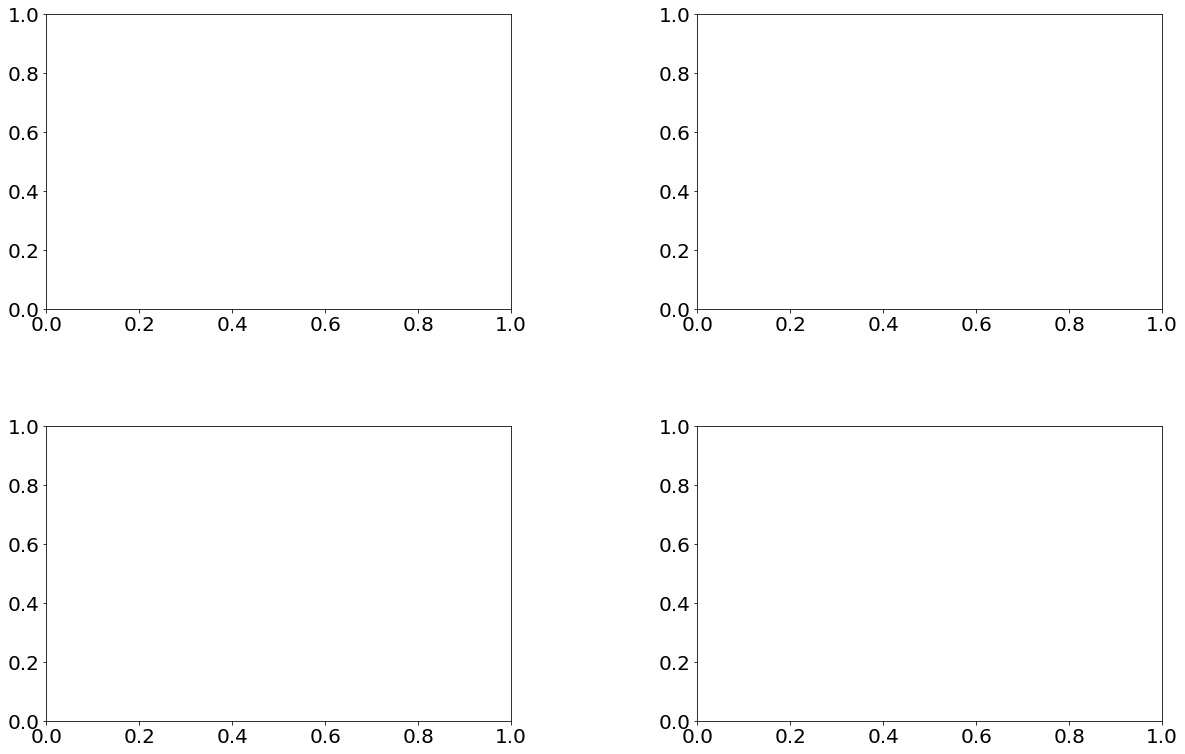

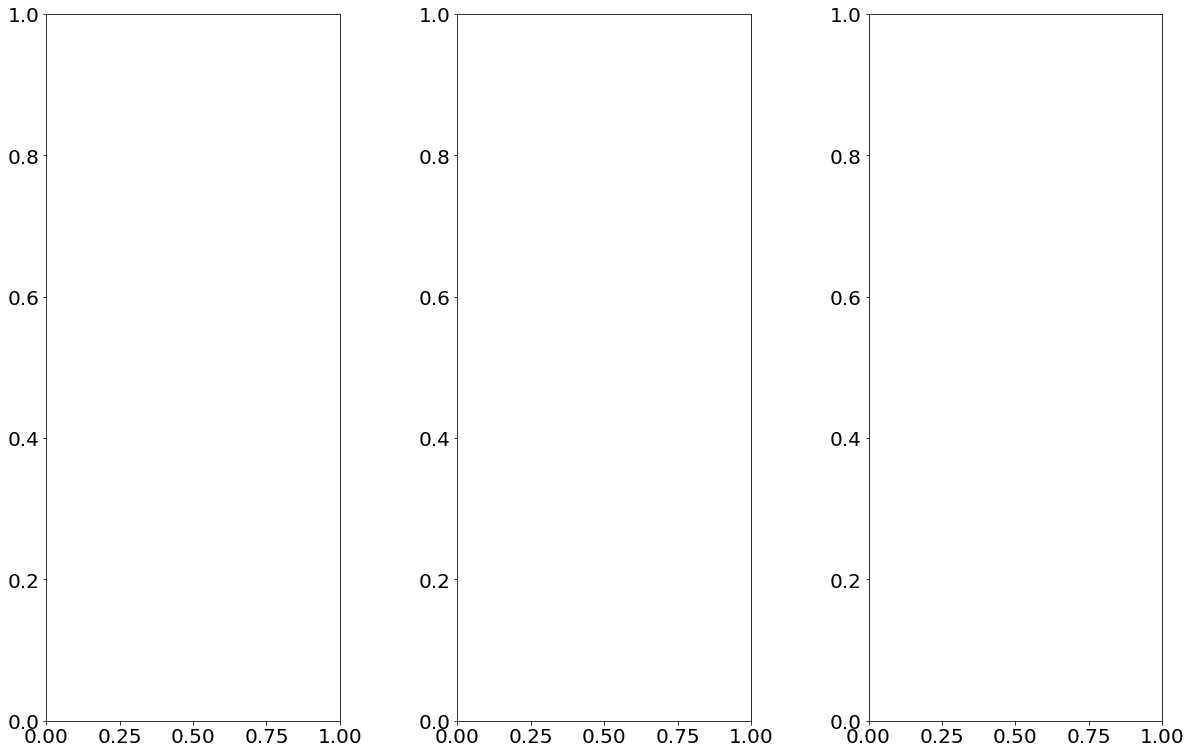

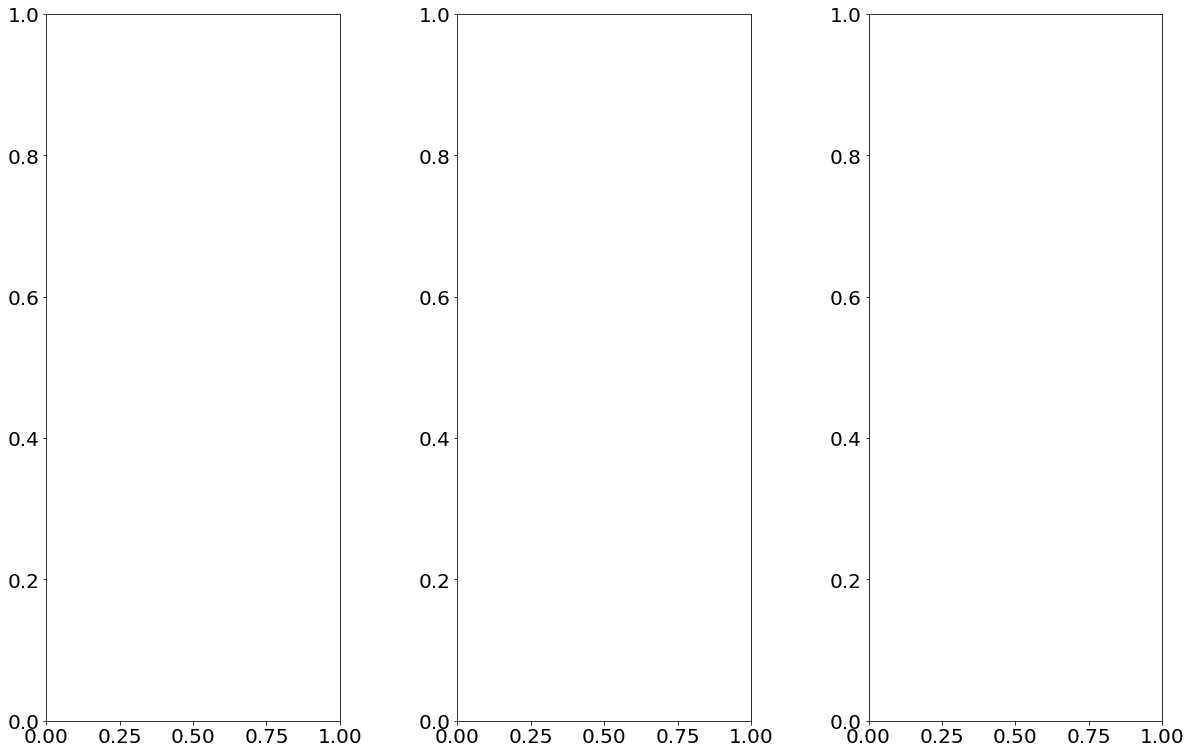

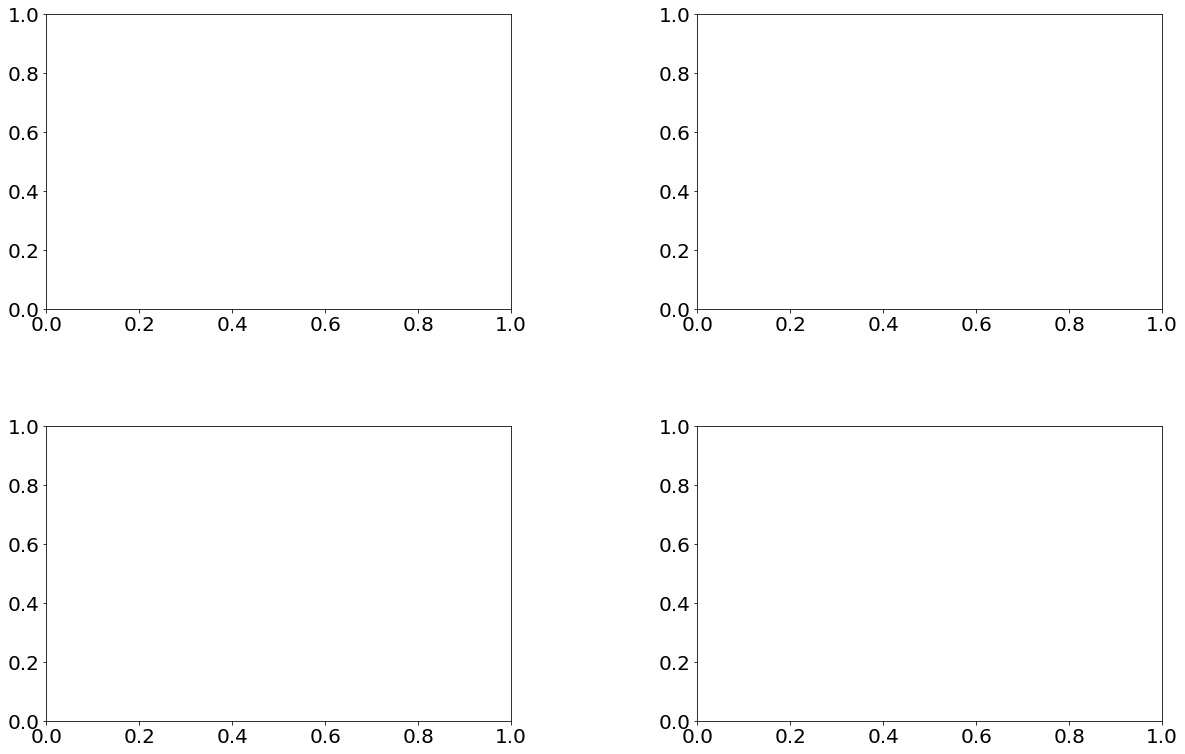

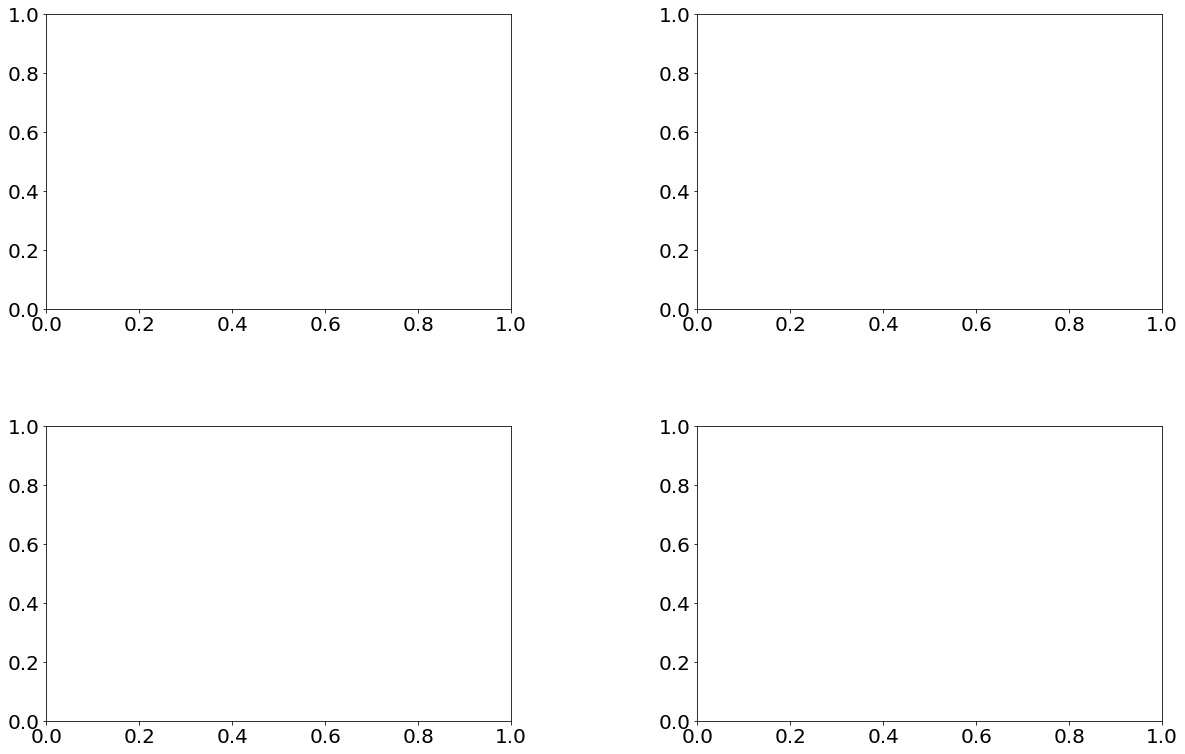

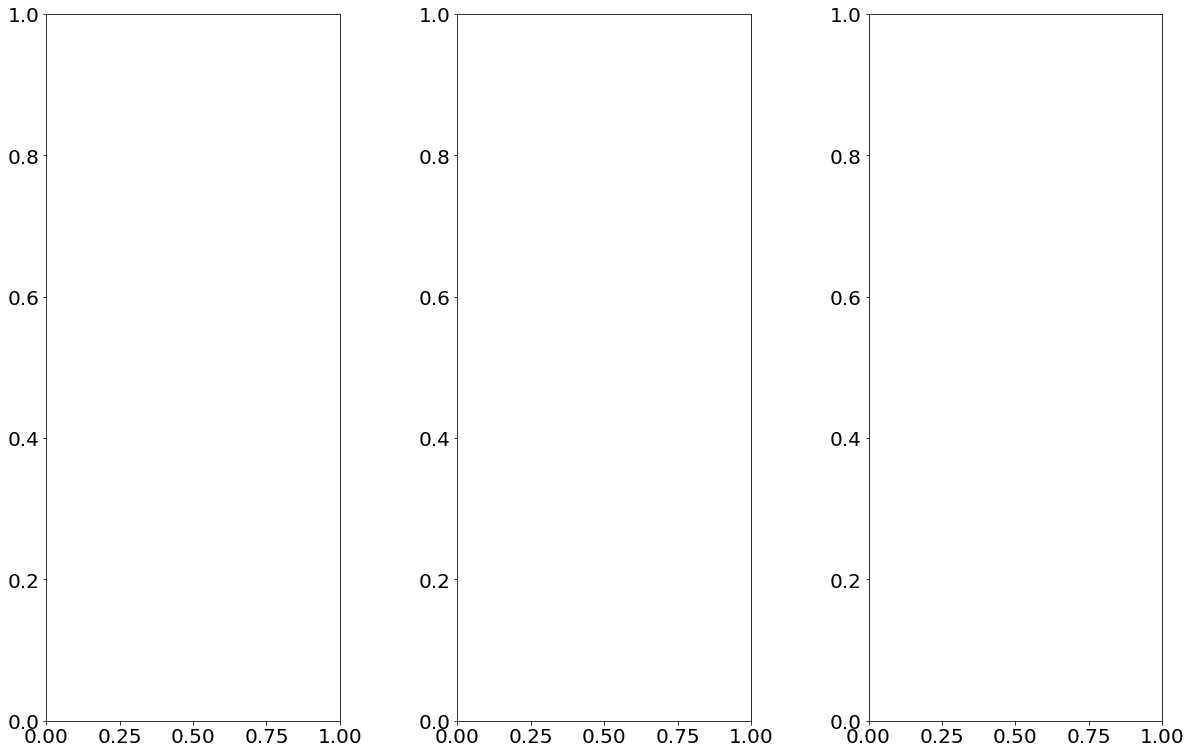

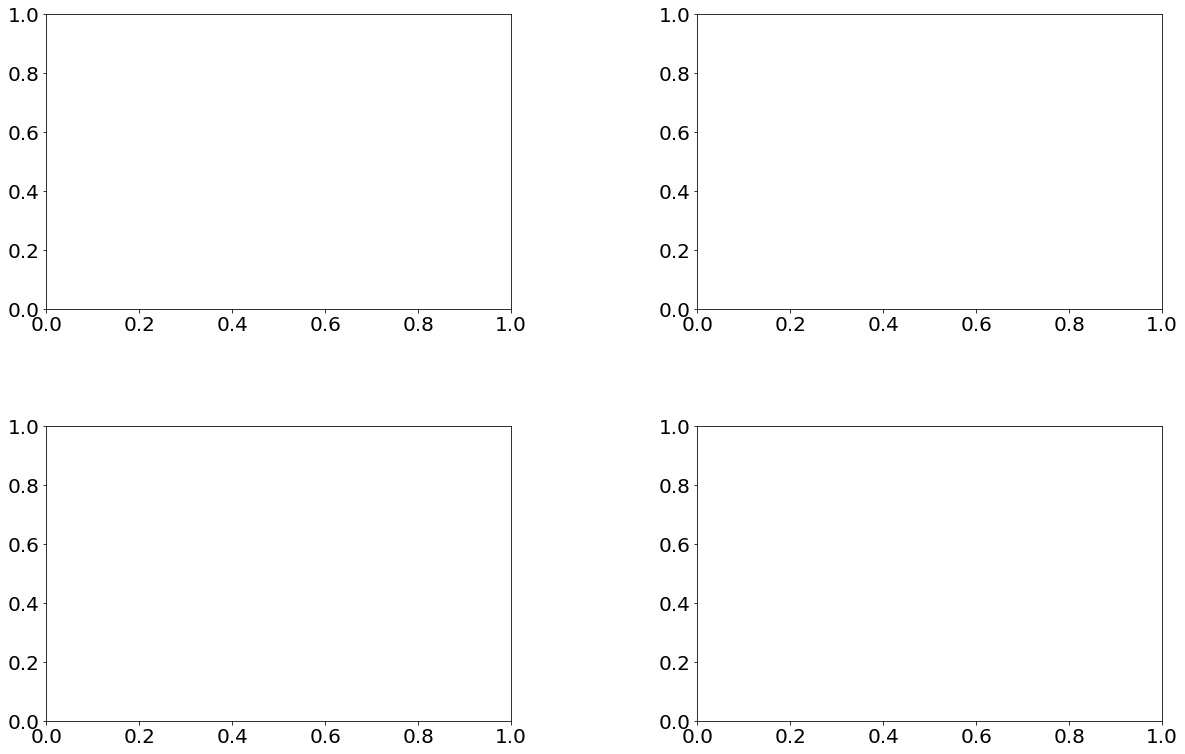

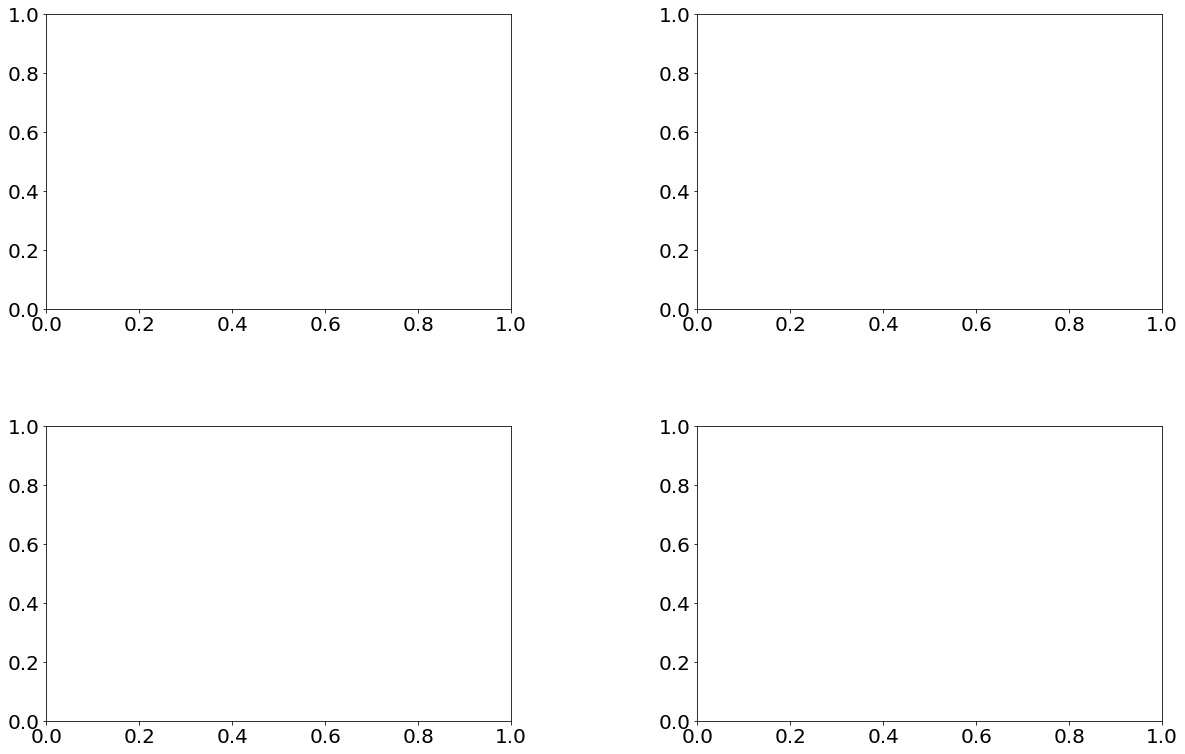

In [ ]:
from chembee.actions.benchmark_algorithms import benchmark_standard

from chembee.config.benchmark.svc import SVClassifier
from chembee.config.benchmark.spectral_clustering import SpectralClusteringClassifier
from chembee.config.benchmark.random_forest import RandomForestClassifier
from chembee.config.benchmark.naive_bayes import NaiveBayesClassifier
from chembee.config.benchmark.logistic_regression import LogisticRegressionClassifier
from chembee.config.benchmark.linear_regression import LinearRegressionClassifier
from chembee.config.benchmark.kmeans import KMeansClassifier
from chembee.config.benchmark.knn import KNNClassifier
from chembee.config.benchmark.mlp_classifier import NeuralNetworkClassifier
from chembee.config.benchmark.restricted_bm import RBMClassifier

algorithms = [
    SVClassifier,
    SpectralClusteringClassifier,
    RandomForestClassifier,
    NaiveBayesClassifier,
    LogisticRegressionClassifier,
    LinearRegressionClassifier,
    KMeansClassifier,
    KNNClassifier,
    NeuralNetworkClassifier,
    RBMClassifier,
]


import numpy as np

X = np.array([X_data[:, 1], X_data[:, 18]]).T
y = y_data
benchmark_standard(
    X,
    y,
    feature_names=["LogP", "InertialShapeFactor"],
    prefix=prefix,
    algorithms=algorithms,
)

# Cross Validation

Now fit several algorithms for the cross validation, then benchmark them again and validate the fit afterwards

In [ ]:
from chembee.actions.cross_validation import (
    screen_cross_validation_grid_search,
)
from chembee.datasets.BioDegDataSet import BioDegDataSet
from chembee.preparation.processing import calculate_lipinski_desc
from chembee.config.calibration.random_forest import RandomForestClassifier
from chembee.config.calibration.knn import KNNClassifier
from chembee.config.calibration.mlp_classifier import NeuralNetworkClassifierRELU
from chembee.config.calibration.svc import NaivelyCalibratedSVCRBF

# you have to use the child class directly, the grandchild doesn't work


data_set_path = "../datasets/AllPublicnew.sdf"
target = "ReadyBiodegradability"
split_ratio = 0.7
scores = [
    "precision_macro",
    "recall_macro",
    "accuracy",
]  # need to specify the loss functions for the crosss validation
DataSet = BioDegDataSet(
    split_ratio=split_ratio, data_set_path=data_set_path, target=target
)
data = calculate_lipinski_desc(DataSet.data, DataSet.mols)
data = DataSet.clean_data(data)
(
    DataSet.X_train,
    DataSet.X_test,
    DataSet.y_train,
    DataSet.y_test,
) = DataSet.make_train_test_split(
    data, split_ratio=split_ratio, y_col=target, shuffle=True
)
DataSet.data = DataSet.clean_data(DataSet.data)
names = [
    "rf",
    "knn",
    "NaivelyCalibratedSVCRBF",
]  # is confusing with the real dict keys
clf_list = [
    RandomForestClassifier,
    KNNClassifier,
    NaivelyCalibratedSVCRBF,
]

3192it [00:17, 184.56it/s]


In [ ]:
import numpy as np

fitted_clf, result_clf = screen_cross_validation_grid_search(
    scores=scores,
    clf_list=clf_list,
    X_train=DataSet.X_train.to_numpy(),
    X_test=DataSet.X_test.to_numpy(),
    y_train=DataSet.y_train.to_numpy().astype(np.int32),
    y_test=DataSet.y_test.to_numpy().astype(np.int32),
    refit="accuracy",
)

In [ ]:
from chembee.utils.file_utils import save_json_to_file

save_json_to_file(fitted_clf, file_name ="70-30.lipinski_cv.json")

In [ ]:
from chembee.config.calibration.knn import KNeighborsClassifierAlgorithm
from chembee.config.calibration.random_forest import RandomForestClassifierAlgorithm
from chembee.config.calibration.mlp_classifier import MLPClassifierAlgorithm
from chembee.config.calibration.svc import NaivelyCalibratedSVC

from sklearn.neighbors import KNeighborsClassifier

rf = RandomForestClassifierAlgorithm(**fitted_clf["rfc"]["best_parameters"])
knn = KNeighborsClassifierAlgorithm(**fitted_clf["knn"]["best_parameters"])
svc = NaivelyCalibratedSVC(**fitted_clf["rbf_svc"]["best_parameters"])
algorithms = [rf, knn, svc]
names = [
    "rf",
    "knn",
    "NaivelyCalibratedSVCRBF",
]

In [ ]:
import numpy as np
from chembee.actions.benchmark_algorithms import (
    benchmark_standard,
    benchmark_cv_algorithms,
)

prefix = "lipinski/aftercv/"
X_data = data.drop(columns=target).to_numpy()
y_data = data[target].to_numpy().astype(np.int32)
X = np.array([X_data[:, 1], X_data[:, 18]]).T
y = y_data



In [ ]:
fitted_clf_list = benchmark_cv_algorithms(
    algorithms=algorithms,
    names=names,
    X=X,
    y=y,
    feature_names=["LogP", "InertialShapeFactor"],
    prefix=prefix,
    to_fit=True,
)

# Evaluation 

In [ ]:
from chembee.actions.evaluation import screen_classifier_for_metrics
from chembee.plotting.evaluation import plot_collection

algorithms = [rf, knn, svc]
fitted_clf = []

for clf in algorithms:
    clf.fit(DataSet.X_train, DataSet.y_train)
    fitted_clf.append(clf)
metrics = screen_classifier_for_metrics(
    X_train=DataSet.X_train,
    X_test=DataSet.X_test,
    y_train=DataSet.y_train.astype(np.int32),
    y_test=DataSet.y_test.astype(np.int32),
    clf_list=fitted_clf,
)

<Figure size 1080x1080 with 0 Axes>

In [ ]:
plot_collection(
    metrics, file_name=DataSet.name + "70-30_lipinski_evaluation", prefix="plots/evaluation"
)

In [ ]:
from chembee.actions.get_false_predictions import get_false_predictions
false_pos_indices = []
false_neg_indices = []
for i in range(5):
    clf = rf.fit(X_data, y_data.astype(np.int32))
    false_pos, false_neg = get_false_predictions(fitted_clf=clf, X_data = X_data, y_true=y_data.astype(np.int32))
    false_pos_indices+= false_pos
    false_neg_indices+= false_neg

In [ ]:
print(len(false_pos_indices))
print(len(false_pos))
print("False positives")
print(len(false_pos_indices))
print(len(false_pos))

4
0
False positives
4
0


# Stratified Evaluation

In [ ]:
from chembee.actions.evaluation import screen_classifier_for_metrics_stratified
from chembee.plotting.evaluation import plot_collection_stratified
n = 5
metrics = screen_classifier_for_metrics_stratified(X_data, y_true=y_data.astype(int), clf_list=algorithms, n=n)
file_name = make_full_filename(prefix="lipinski/aftercv/", file_name="-70-30-lipinski_evaluation.json")
save_json_to_file(file_name=file_name, dictionary=metrics)


In [ ]:
from chembee.plotting.evaluation import plot_collection_stratified
plot_collection_stratified(
    metrics, file_name=DataSet.name + "70-30-lipinski_reduced_evaluation", prefix="plots/evaluation"
)

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

# Cross validation


In [ ]:
import matplotlib.pyplot as plt 
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np 
from sklearn.metrics import accuracy_score
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=120, shuffle=True)
classifier = rf
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


accuracies = []
interesting_compounds = []
for i, (train, test) in enumerate(cv.split(X_data, y_data.astype(np.int32))):
    classifier.fit(X_data[train], y_data.astype(np.int32)[train])
    y_pred = classifier.predict(X_data[test])
    score = accuracy_score(y_pred, y_data.astype(np.int32)[test])
    if score <= 0.7:
        interesting_compounds.append(test)
    accuracies.append(float(score))

In [ ]:
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Split")

Text(0.5, 0, 'Split')

In [ ]:
interesting_compounds

[array([ 172,  323,  534,  566,  850,  896, 1035, 1479, 1562, 1615, 1762,
        1766, 1790, 1819, 1908, 2106, 2191, 2274, 2547, 2639, 2649, 2651,
        2718, 2739, 2847, 2851, 2904]),
 array([  44,   63,  131,  207,  317,  497,  508,  601,  736,  767, 1118,
        1671, 1917, 1995, 2162, 2388, 2419, 2503, 2505, 2517, 2606, 2654,
        2679, 2980, 3063, 3152]),
 array([ 324,  446,  843,  882, 1149, 1628, 1656, 1675, 1747, 1826, 1897,
        2036, 2071, 2146, 2152, 2370, 2529, 2563, 2608, 2687, 2697, 2818,
        2977, 3047, 3054, 3188]),
 array([ 454,  679, 1058, 1251, 1370, 1507, 1530, 1586, 1595, 1644, 1797,
        1798, 1830, 1949, 1978, 2070, 2248, 2260, 2394, 2438, 2650, 2653,
        2704, 3008, 3109, 3190]),
 array([  22,   81,  101,  158,  248,  330,  366,  372,  633,  693,  741,
         810,  875, 1081, 1114, 1144, 1199, 1481, 2090, 2099, 2216, 2601,
        2624, 2918, 2954, 3019]),
 array([  83,  188,  206,  342,  360,  632, 1024, 1062, 1070, 1246, 1263,
        12

In [ ]:
from chembee.preparation.processing import calculate_mordred_descriptors, calculate_lipinski_desc, convert_mol_to_inchi, convert_mols_to_morgan_fp, convert_mols_to_rdk_fp,  get_mols_from_supplier
from chembee.actions.search import  screen_fingerprints_against_data, get_similar_compounds
weird_compounds = get_mols_from_supplier(supplier=DataSet.mols, indices=interesting_compounds[0].tolist())

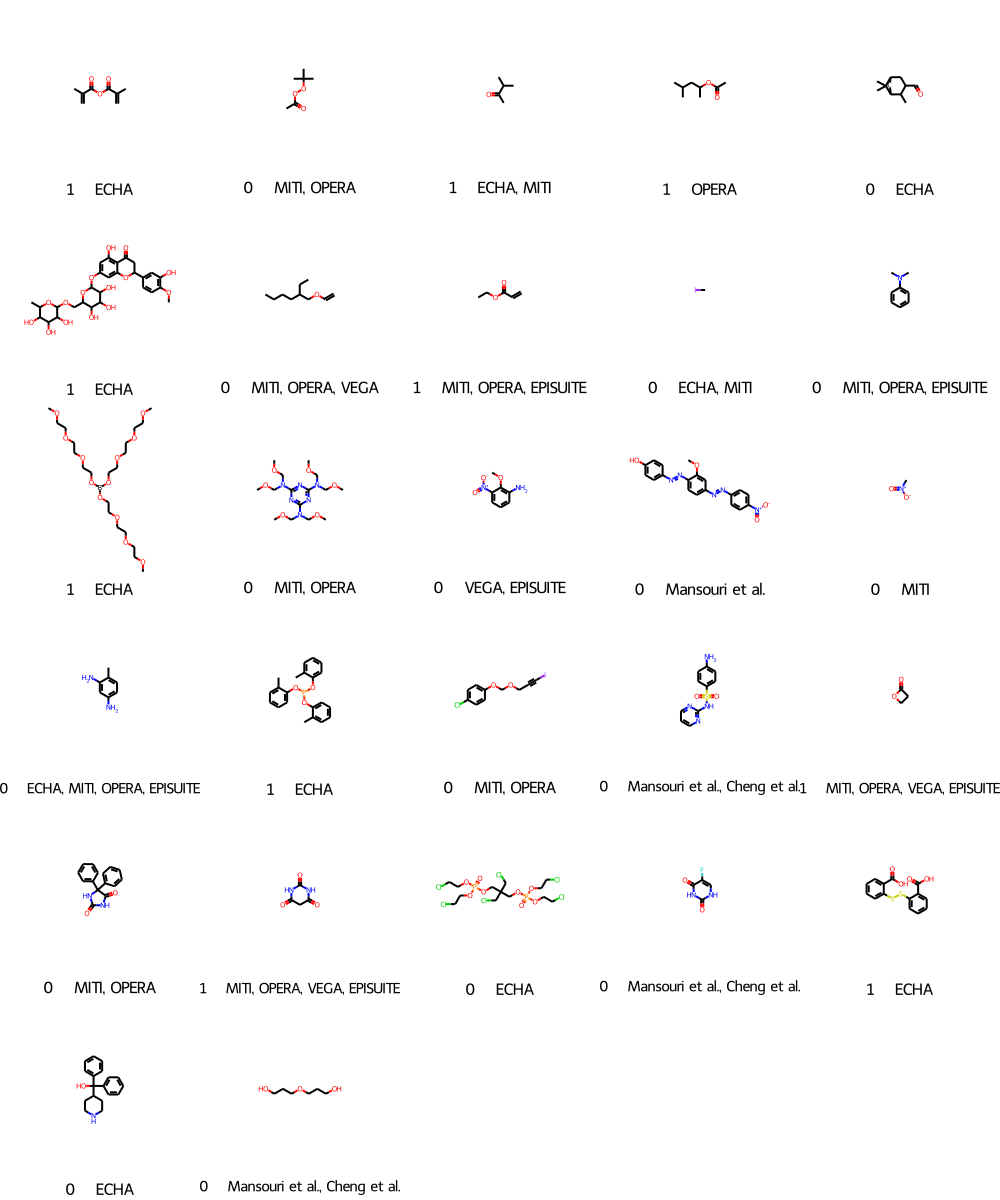

In [ ]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(weird_compounds,molsPerRow=5,subImgSize=(200,200),legends=[x.GetProp("ReadyBiodegradability") + "    " + x.GetProp("Dataset") for x in weird_compounds])    


In [ ]:
print(np.mean(accuracies))
top5 = []
for indx in np.argpartition(accuracies, -5)[-5:]: 
    top5.append(accuracies[indx])
print(np.mean(top5))

0.8026115859449194
0.9478632478632478


In [ ]:
print(top5)

[0.9259259259259259, 0.9259259259259259, 0.9615384615384616, 0.9629629629629629, 0.9629629629629629]


In [ ]:
import matplotlib.pyplot as plt 
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import numpy as np 
from sklearn.metrics import accuracy_score
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=120, shuffle=True)
classifier = knn
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


accuracies = []
interesting_compounds = []
for i, (train, test) in enumerate(cv.split(X_data, y_data.astype(np.int32))):
    classifier.fit(X_data[train], y_data.astype(np.int32)[train])
    y_pred = classifier.predict(X_data[test])
    score = accuracy_score(y_pred, y_data.astype(np.int32)[test])
    if score <= 0.6:
        interesting_compounds.append(test)
    accuracies.append(float(score))

In [ ]:
plt.plot(accuracies)

In [ ]:
print(len(interesting_compounds))
print(interesting_compounds)

2
[array([ 234,  278,  306,  320,  364,  463,  548,  897, 1106, 1136, 1165,
       1520, 1608, 1778, 1821, 1969, 2019, 2070, 2438, 2503, 2526, 2690,
       2709, 2747, 2751, 2783, 3191]), array([  14,  147,  158,  176,  281,  297,  331,  678,  936, 1047, 1130,
       1143, 1166, 1191, 1372, 1471, 1644, 1649, 1746, 1840, 1908, 1946,
       1947, 2588, 2680, 2796, 2969])]


In [ ]:
print(np.mean(accuracies))
top5 = []
for indx in np.argpartition(accuracies, -5)[-5:]: 
    top5.append(accuracies[indx])
print(np.mean(top5))

0.7891263057929725
0.9401709401709402


In [ ]:
from chembee.preparation.processing import calculate_mordred_descriptors, calculate_lipinski_desc, convert_mol_to_inchi, convert_mols_to_morgan_fp, convert_mols_to_rdk_fp,  get_mols_from_supplier
from chembee.actions.search import  screen_fingerprints_against_data, get_similar_compounds
weird_compounds = get_mols_from_supplier(supplier=DataSet.mols, indices=interesting_compounds[0].tolist())

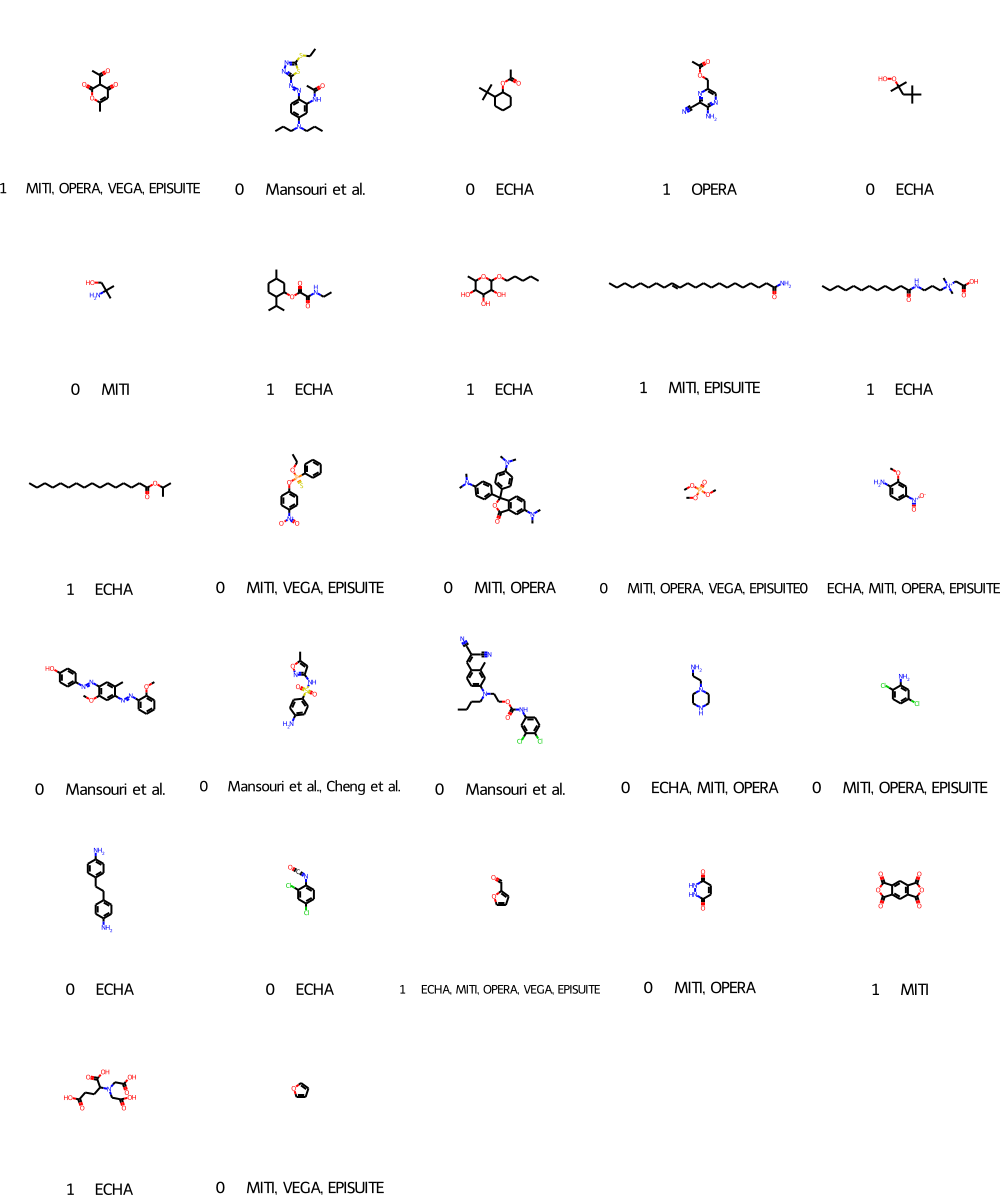

In [ ]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(weird_compounds,molsPerRow=5,subImgSize=(200,200),legends=[x.GetProp("ReadyBiodegradability") + "    " + x.GetProp("Dataset") for x in weird_compounds])    


# Applicability Domain

In [ ]:
from pyADA import ApplicabilityDomain
import numpy as np

threshold_step = (0, 1.05, 0.05)
ad = ApplicabilityDomain(verbose=True)
res = ad.fit(
        model=rf,
        base_test=DataSet.X_test.to_numpy(),
        base_train=DataSet.X_train.to_numpy(),
        y_true=DataSet.y_test.to_numpy().astype(np.int32),
        threshold_reference="max",
        threshold_step=threshold_step,
        similarity_metric="tanimoto",
        alpha=1,
        beta=1,
        metric_avaliation="auc",
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 13.80it/s]


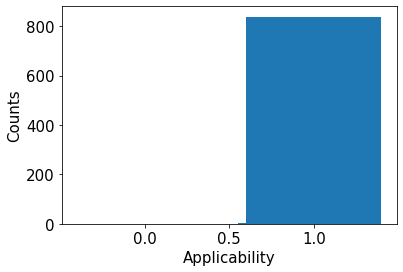

In [ ]:
import matplotlib.pyplot as plt 

counts = []
for i, key in enumerate(res.keys()): 
    count = len(res[key][1])
    counts.append(count)

plt.bar(np.arange(0, 1.05, 0.05), counts)
plt.xlabel("Applicability")
plt.ylabel("Counts")
plt.savefig("70-30_applicability_lip.png", dpi = 300)